Very similar to the main `open_cp` code

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import geopandas as gpd
import os, collections, lzma, json
import numpy as np

import open_cp.network
import open_cp.geometry
import matplotlib.patches

import tilemapbase
import pyproj
proj = pyproj.Proj({"init":"epsg:3528"})
import descartes, shapely.geometry

In [2]:
def project_to_tilemapbase(points):
    points = np.asarray(points)
    assert points.shape[-1] == 2
    xc, yc = proj(points[:,0], points[:,1], inverse=True)
    xcs, ycs = [], []
    for (x,y) in zip(xc, yc):
        x, y = tilemapbase.project(x, y)
        xcs.append(x)
        ycs.append(y)
    return np.asarray([xcs, ycs]).T

## Geometry source

We'll use the TIGER/Lines data.  It doesn't, once we've washed through our graph code, seem to matter too much if we use the `roads` or `edges` data.  The `edges` data contains more, irrelevant, lines, and so we decide not to use it.

In [3]:
tiger_path = os.path.join("/media", "disk", "TIGER Data")
#tiger_path = os.path.join("/media", "OTHERDATA", "TIGER Data")
#iger_path = os.path.join("..", "..", "..", "..", "..", "Data", "TIGER Data")

In [4]:
filename = os.path.join(tiger_path, "tl_2016_17031_roads")
tiger_frame = gpd.GeoDataFrame.from_file(filename)
chicago = tiger_frame.to_crs({"init":"epsg:3528"})
chicago.head()

FULLNAME       LINEARID  MTFCC RTTYP  \
0     47th Pl Exd   110380277026  S1400     M   
1      Golden Spr   110380298305  S1400     M   
2  Edens Expy Spr  1104259027148  S1100     M   
3  Edens Expy Spr  1104259564382  S1100     M   
4  Edens Expy Spr  1104472109755  S1100     M   

                                            geometry  
0  LINESTRING (361283.8098974457 571774.357903373...  
1  LINESTRING (334283.9373028304 555952.566653928...  
2  LINESTRING (338674.4822622131 608835.390285893...  
3  LINESTRING (341418.6466204406 608352.224489629...  
4  LINESTRING (337922.7936322958 609174.983032155...

In [5]:
all_nodes = []
for geo in chicago.geometry:
    for pt in geo.coords:
        all_nodes.append(pt)
        
b = open_cp.network.PlanarGraphNodeOneShot(all_nodes)
name_lookup = collections.defaultdict(set)
for geo, name in zip(chicago.geometry, chicago.FULLNAME):
    path = list(geo.coords)
    for e in b.add_path(path):
        name_lookup[e].add(name)

b.remove_duplicate_edges()
graph = b.build()

In [6]:
edge_name_lookup = collections.defaultdict(set)
for (v1,v2), names in name_lookup.items():
    e, _ = graph.find_edge(v1, v2)
    edge_name_lookup[e].update(names)

In [7]:
assert list(range(graph.number_edges)) == list(edge_name_lookup)
graph.number_edges

942922

In [8]:
with open("chicago.graph", "wb") as f:
    f.write( graph.dump_bytes() )
    
with lzma.open("chicago_graph_names.xz", "wt") as f:
    json.dump({k:list(v) for k,v in edge_name_lookup.items()}, f)

In [9]:
assert not all(len(v) == 1 for v in edge_name_lookup.values())

## Does the same thing happen for `edges`?

No.  We seem to get a unique name for each edge...!

In [10]:
filename = os.path.join(tiger_path, "tl_2016_17031_edges")
tiger_frame = gpd.GeoDataFrame.from_file(filename)
chicagoe = tiger_frame.to_crs({"init":"epsg:3528"})
chicagoe.head()

ARTPATH COUNTYFP DECKEDROAD DIVROAD EXTTYP FEATCAT     FULLNAME GCSEFLG  \
0    None      031       None    None      N    None         None       N   
1       N      031       None    None      N       L  Great Lakes       N   
2    None      031       None    None      N    None         None       N   
3    None      031       None    None      N    None         None       N   
4    None      031       None    None      N    None         None       N   

  HYDROFLG LFROMADD                        ...                          \
0        N     None                        ...                           
1        N     None                        ...                           
2        N     None                        ...                           
3        N     None                        ...                           
4        N     None                        ...                           

  STATEFP      TFIDL      TFIDR       TLID      TNIDF      TNIDT  TTYP  ZIPL  \
0      17  205026959  250409380  630009250  419075567   66443071  None  None   
1      17  227443517  227443516  613720666  407309993  407309994  None  None   
2      17  250409506  257825701  630009366  419075613  419075603  None  None   
3      17  250409499  250409498  630009476   66489213  419075651  None  None   
4      17  250409386  250409320  630009160  419075532  419075537  None  None   

   ZIPR                                           geometry  
0  None  LINESTRING (364405.5379445553 567268.128558744...  
1  None  LINESTRING (363194.8858743247 567861.246061401...  
2  None  LINESTRING (358543.3791577177 585961.056174848...  
3  None  LINESTRING (357948.3889643896 588986.831090772...  
4  None  LINESTRING (363495.2114223191 568083.949034775...  

[5 rows x 32 columns]

In [11]:
chicagoe.columns

Index(['ARTPATH', 'COUNTYFP', 'DECKEDROAD', 'DIVROAD', 'EXTTYP', 'FEATCAT',
       'FULLNAME', 'GCSEFLG', 'HYDROFLG', 'LFROMADD', 'LTOADD', 'MTFCC',
       'OFFSETL', 'OFFSETR', 'OLFFLG', 'PASSFLG', 'PERSIST', 'RAILFLG',
       'RFROMADD', 'ROADFLG', 'RTOADD', 'SMID', 'STATEFP', 'TFIDL', 'TFIDR',
       'TLID', 'TNIDF', 'TNIDT', 'TTYP', 'ZIPL', 'ZIPR', 'geometry'],
      dtype='object')

In [12]:
all_nodes = []
for geo in chicagoe.geometry:
    for pt in geo.coords:
        all_nodes.append(pt)
        
b = open_cp.network.PlanarGraphNodeOneShot(all_nodes)
name_lookupe = collections.defaultdict(set)
for index, row in chicagoe.iterrows():
    geo = row.geometry
    path = list(geo.coords)
    data = (row.FULLNAME, row.LFROMADD, row.LTOADD, row.RFROMADD, row.RTOADD)
    for e in b.add_path(path):
        name_lookupe[e].add(data)

b.remove_duplicate_edges()
graphe = b.build()

In [13]:
edge_name_lookupe = collections.defaultdict(set)
for (v1,v2), names in name_lookupe.items():
    e, _ = graphe.find_edge(v1, v2)
    edge_name_lookupe[e].update(names)

In [14]:
assert all(len(v) == 1 for v in edge_name_lookupe.values())

## Combine

For each edge in the "roads graph" see if there is an edge in the "edges graph"...

We find there there is just one missing bit of data

In [15]:
# Cheat and use the builder; turns out all vertices are shared...
graph_to_graphe_vertex_lookup = {v : b._lookup[pt] for v, pt in graph.vertices.items()}   

In [16]:
canonical_names_lookup = dict()
for e, (v1,v2) in enumerate(graph.edges):
    ee, _ = graphe.find_edge(graph_to_graphe_vertex_lookup[v1], graph_to_graphe_vertex_lookup[v2])
    addresses = list(edge_name_lookupe[ee])
    assert len(addresses) == 1
    address = addresses[0]
    if not address[0] in edge_name_lookup[e]:
        print(e, edge_name_lookup[e], ee, edge_name_lookupe[ee])
    canonical_names_lookup[e] = address

403281 {None} 235130 {('Pct Line', None, None, None, None)}


In [17]:
with lzma.open("chicago_graph_addresses.xz", "wt") as f:
    json.dump(canonical_names_lookup, f)

## Save to shapefile

In [18]:
geo = []
for (v1, v2) in graph.edges:
    geo.append( shapely.geometry.LineString([graph.vertices[v1], graph.vertices[v2]]) )

names = []
for i in range(graph.number_edges):
    options = list(edge_name_lookup[i])
    while len(options) < 6:
        options.append("")
    names.append(options)
    
frame = gpd.GeoDataFrame({
    "edge" : list(range(graph.number_edges)),
    "name" : [canonical_names_lookup[e][0] for e in range(graph.number_edges)],
    "lfrom" : [canonical_names_lookup[e][1] for e in range(graph.number_edges)],
    "lto" : [canonical_names_lookup[e][2] for e in range(graph.number_edges)],
    "rfrom" : [canonical_names_lookup[e][3] for e in range(graph.number_edges)],
    "rto" : [canonical_names_lookup[e][4] for e in range(graph.number_edges)]
    })
for i in range(6):
    frame["option{}".format(i+1)] = [k[i] for k in names]
frame.geometry = geo
frame.crs = {"init":"epsg:3528"}
frame.head()

edge lfrom   lto        name rfrom   rto     option1      option2 option3  \
0     0  None  None   E 44th Pl  None  None   E 44th Pl  47th Pl Exd           
1     1  None  None   E 44th Pl  None  None   E 44th Pl  47th Pl Exd           
2     2  None  None   E 44th Pl  None  None   E 44th Pl  47th Pl Exd           
3     3    99     1  Golden Spr     2    98  Golden Spr                        
4     4    99     1  Golden Spr     2    98  Golden Spr                        

  option4 option5 option6                                           geometry  
0                          LINESTRING (361283.8098974457 571774.357903373...  
1                          LINESTRING (361289.0197482831 571777.290601876...  
2                          LINESTRING (361304.3990535857 571786.197648249...  
3                          LINESTRING (334283.9373028304 555952.566653928...  
4                          LINESTRING (334295.7171578573 555961.952578487...

In [19]:
frame.to_file("chicago_graph_details")

# Find "segments"

By a "segment" we mean a series of edges whose "internal" nodes have degree two.

In [20]:
with open("chicago.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

In [21]:
segments = list(open_cp.network.segment_graph(graph))
ordered_segments = list(open_cp.network.ordered_segment_graph(graph))
len(segments)

233425

In [22]:
with lzma.open("chicago_graph_segments.json.xz", "wt") as f:
    json.dump([[int(x) for x in y] for y in ordered_segments], f)

# Voroni from segments

In [23]:
vpoints = []
for vertices in ordered_segments:
    x1, y1 = graph.vertices[vertices[0]]
    x2, y2 = graph.vertices[vertices[1]]
    # Crude...
    x, y = (x1+x2)/2, (y1+y2)/2
    vpoints.append((x,y))
    
    x1, y1 = graph.vertices[vertices[-1]]
    x2, y2 = graph.vertices[vertices[-2]]
    x, y = (x1+x2)/2, (y1+y2)/2
    vpoints.append((x,y))
    
vpoints = list(set(vpoints))

In [24]:
vpoints = project_to_tilemapbase(vpoints)

In [25]:
voroni = open_cp.geometry.Voroni(vpoints)

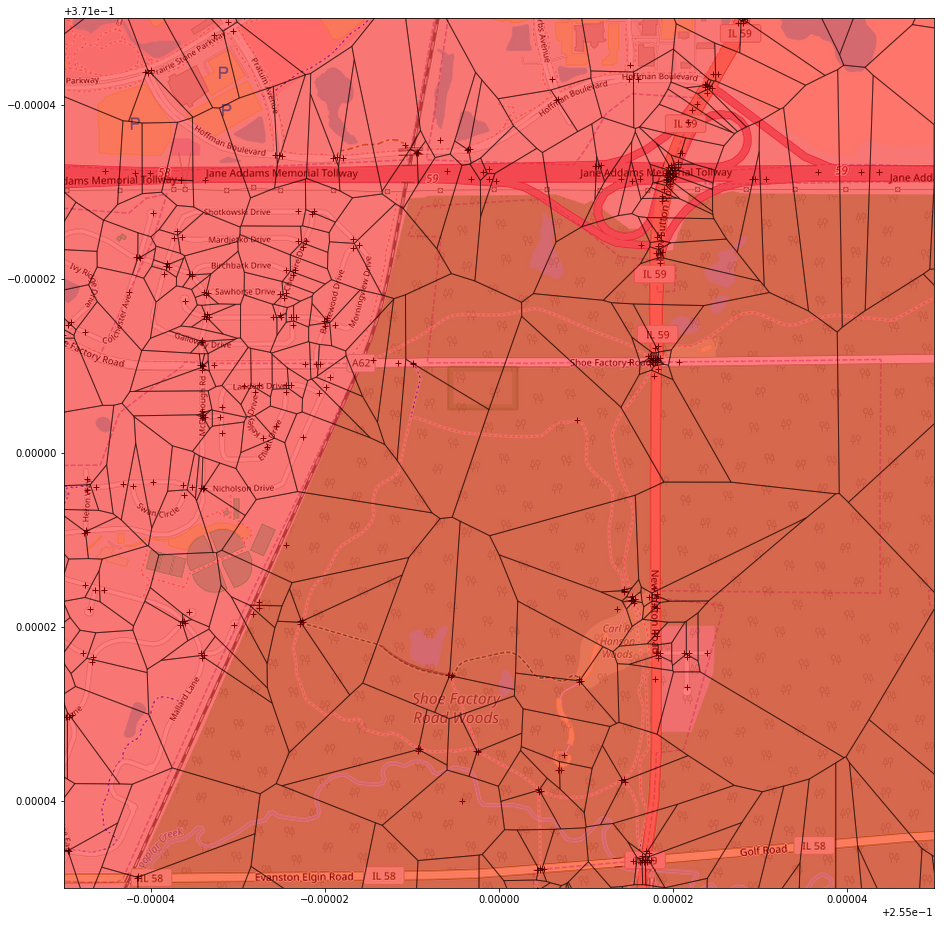

In [26]:
fig, ax = plt.subplots(figsize=(16,16))
ex = tilemapbase.Extent.from_centre(0.255, 0.371, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for i, (x,y) in enumerate(vpoints):
    d = (x-0.255)**2 + (y-0.371)**2
    if d < 0.000001:
        poly = voroni.polygon_for(i)
        p = matplotlib.patches.Polygon(poly, ec="black", fc="red", alpha=0.5)
        ax.add_patch(p)

ax.scatter(*vpoints.T, marker="+", color="black", linewidth=1)

# Voroni from edges?

In [27]:
with open("chicago.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

In [28]:
points = []
for e in graph.edges:
    x1, y1 = graph.vertices[e[0]]
    x2, y2 = graph.vertices[e[1]]
    points.append( ((x1+x2)/2, (y1+y2)/2) )
points = np.asarray(points)

In [29]:
pt_wm = project_to_tilemapbase(points)

In [30]:
voroni = open_cp.geometry.Voroni(points)

In [31]:
import shapely.geometry

polygons_for_segments = []
for segment in segments:
    polys = [shapely.geometry.Polygon(voroni.polygon_for(e)) for e in segment]
    poly = polys[0]
    for p in polys[1:]:
        poly = poly.union(p)
    polygons_for_segments.append(poly)

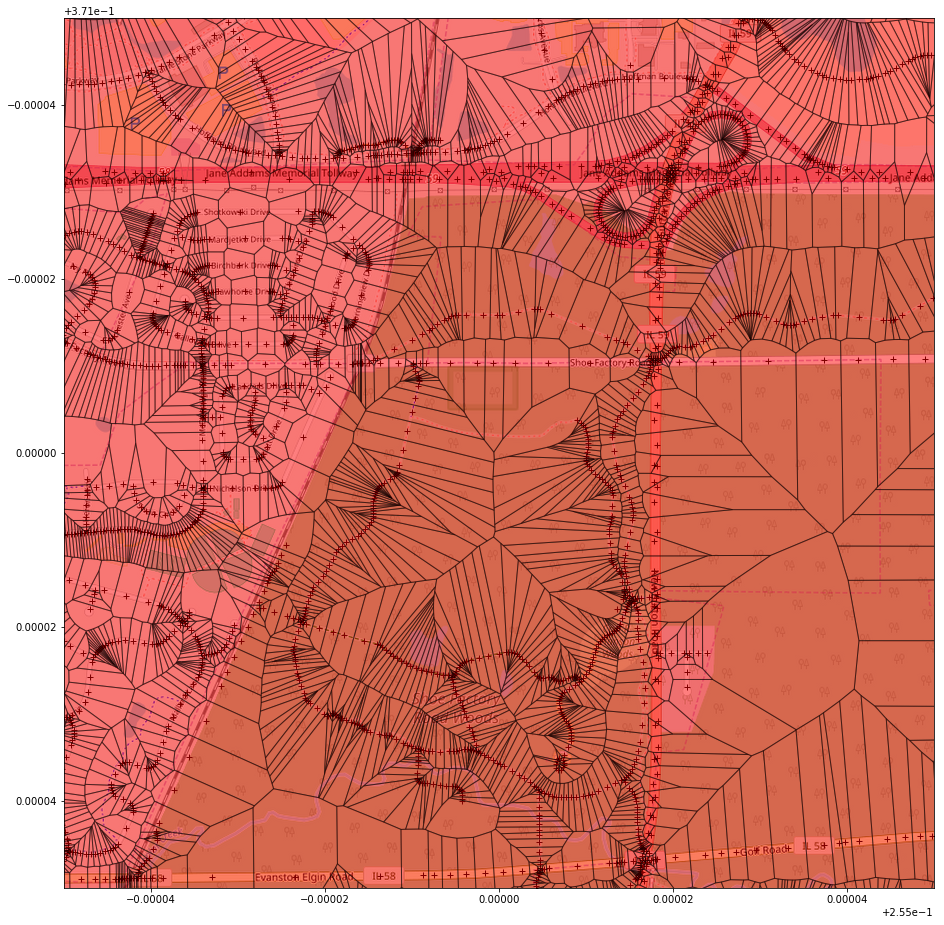

In [32]:
fig, ax = plt.subplots(figsize=(16,16))
ex = tilemapbase.Extent.from_centre(0.255, 0.371, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for i, (x,y) in enumerate(pt_wm):
    d = (x-0.255)**2 + (y-0.371)**2
    if d < 0.0001**2:
        poly = voroni.polygon_for(i)
        poly = project_to_tilemapbase(poly)
        p = matplotlib.patches.Polygon(poly, ec="black", fc="red", alpha=0.5)
        ax.add_patch(p)

ax.scatter(*pt_wm.T, marker="+", color="black", linewidth=1)

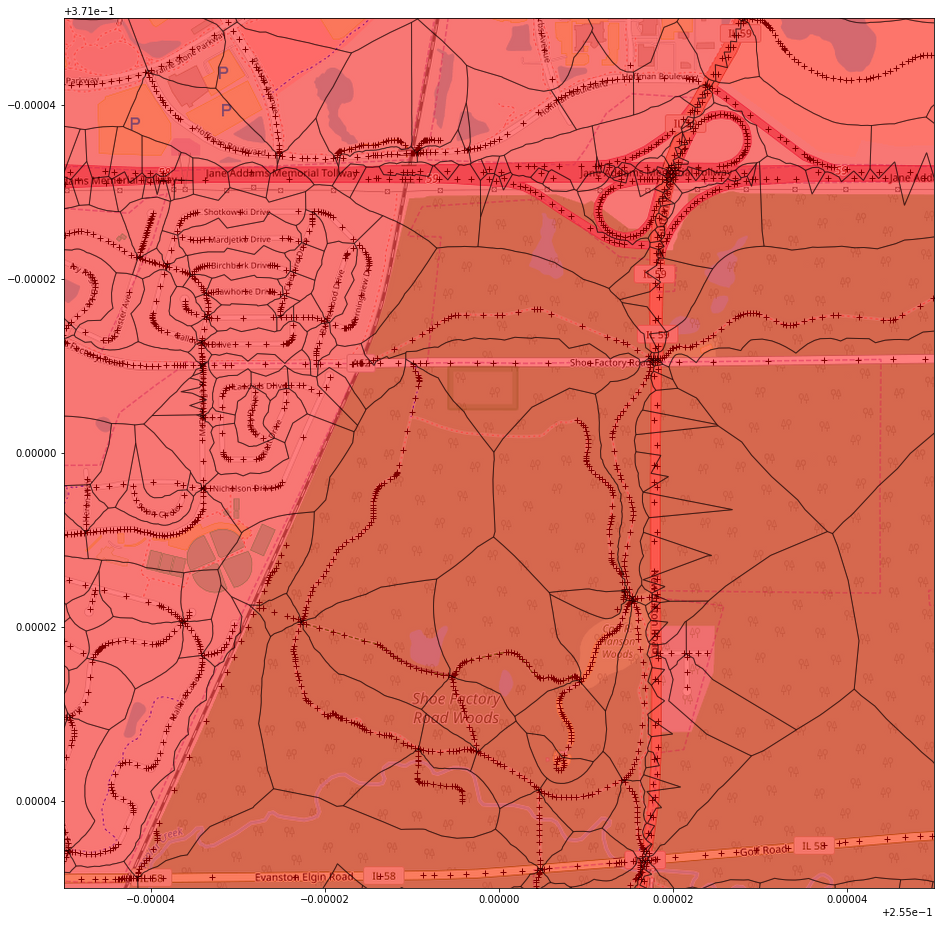

In [33]:
fig, ax = plt.subplots(figsize=(16,16))
ex = tilemapbase.Extent.from_centre(0.255, 0.371, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for p in polygons_for_segments:
    coords = []
    try:
        for poly in p:
            coords.append( list(poly.exterior.coords) )
    except:
        coords.append( list(p.exterior.coords) )
    for poly in coords:
        poly = project_to_tilemapbase(poly)
        x, y = poly[0]
        d = (x-0.255)**2 + (y-0.371)**2
        if d < 0.0001**2:
            p = matplotlib.patches.Polygon(poly, ec="black", fc="red", alpha=0.5)
            ax.add_patch(p)
        
ax.scatter(*pt_wm.T, marker="+", color="black", linewidth=1)

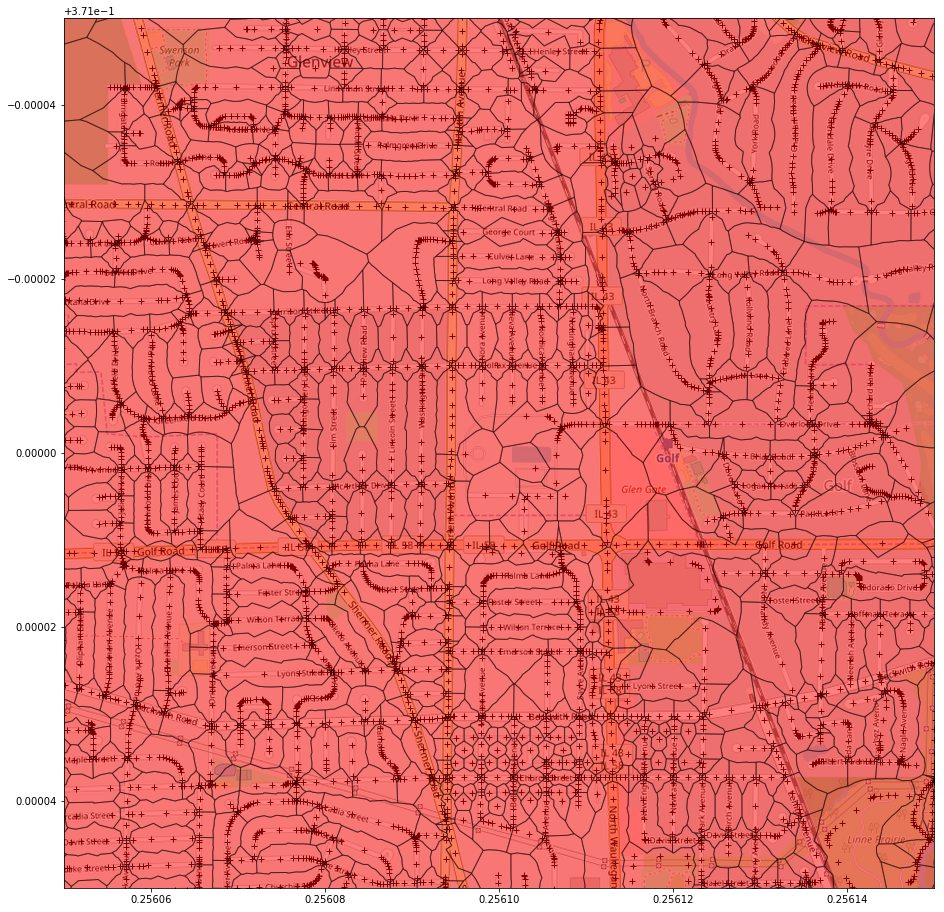

In [34]:
fig, ax = plt.subplots(figsize=(16,16))
ex = tilemapbase.Extent.from_centre(0.2561, 0.371, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
plotter.plot(ax)

for p in polygons_for_segments:
    coords = []
    try:
        for poly in p:
            coords.append( list(poly.exterior.coords) )
    except:
        coords.append( list(p.exterior.coords) )
    for poly in coords:
        poly = project_to_tilemapbase(poly)
        x, y = poly[0]
        d = (x-0.2561)**2 + (y-0.371)**2
        if d < 0.0001**2:
            p = matplotlib.patches.Polygon(poly, ec="black", fc="red", alpha=0.5)
            ax.add_patch(p)

ax.scatter(*pt_wm.T, marker="+", color="black", linewidth=1)

Quite like this effect...!